In [23]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
train = pd.read_csv('optiver-realized-volatility-prediction/train.csv')
test = pd.read_csv('optiver-realized-volatility-prediction/test.csv')
len(train)

428932

In [3]:
book_train = pd.read_parquet('optiver-realized-volatility-prediction/book_train.parquet/stock_id=0')
book_test = pd.read_parquet('optiver-realized-volatility-prediction/book_test.parquet/stock_id=0')
trade_train = pd.read_parquet('optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0')
trade_test = pd.read_parquet('optiver-realized-volatility-prediction/trade_test.parquet/stock_id=0')

In [4]:
trade_train.head()

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


In [5]:
book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100


In [6]:
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [7]:
test.head()

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [8]:
book_filepath = "optiver-realized-volatility-prediction/book_train.parquet"
trade_filepath = "optiver-realized-volatility-prediction/trade_train.parquet"

book_filenames = os.listdir(book_filepath)
trade_filenames = os.listdir(trade_filepath)

In [9]:
# sample book data
sample = pd.read_parquet(os.path.join(book_filepath, book_filenames[1]))
sample.head(3)

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.000754,1.001542,1.000689,1.001607,1,25,25,100
1,5,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100
2,5,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125


In [10]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

In [11]:
def get_train_data(stock_id):
    stock_id = int(stock_id[9:])
    return train[train['stock_id'] == stock_id]

def get_book_data(stock_id, filepath):
    path  = filepath + "/" + stock_id
    data = pd.read_parquet(path)
    data.insert(0, 'stock_id', int(stock_id[9:]))
    data['wap1'] = (data['bid_price1']*data['ask_size1']+data['ask_price1']*data['bid_size1'])/(data['bid_size1']+data['ask_size1'])
    data['wap2'] = (data['bid_price2']*data['ask_size2']+data['ask_price2']*data['bid_size2'])/(data['bid_size2']+data['ask_size2'])
    data['log_return1'] = log_return(data['wap1']) # this is weighted average price
    data['log_return2'] = log_return(data['wap2']) # also weighted average price
    data['log_return1'] = data['log_return1'].fillna(0)
    data['log_return2'] = data['log_return2'].fillna(0)
    data['spread1'] = data['ask_price1'] / data['bid_price1'] - 1 
    data['spread2'] = data['ask_price2'] / data['bid_price2'] - 1 
    return data

def get_trade_data(stock_id, filepath):
    path  = filepath + "/" + stock_id
    data = pd.read_parquet(path)
    data.insert(0, 'stock_id', int(stock_id[9:]))
    return data

def get_book_volatility(data):
    #volatility1 = realized_volatility(data['log_return1'])
    #volatility2 = realized_volatility(data['log_return2'])
    data = data.groupby(['stock_id', 'time_id'])['log_return1', 'log_return2'].agg(realized_volatility).reset_index()
    data.rename(columns = {'log_return1': 'volatility1', 'log_return2': 'volatility2'}, inplace = True)
    return data
    


In [12]:
d = get_book_data(book_filenames[0], book_filepath)
d

,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap1,wap2,log_return1,log_return2,spread1,spread2
0,0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,1.001434,1.001390,0.000000,0.000000,0.000878,0.000981
1,0,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,1.001448,1.001390,0.000014,0.000000,0.000878,0.000981
2,0,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,1.001448,1.001391,0.000000,0.000001,0.000878,0.001033
3,0,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,1.001443,1.001391,-0.000005,0.000000,0.000878,0.001033
4,0,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,1.001443,1.001391,0.000000,0.000000,0.000878,0.001033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917548,0,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28,0.998515,0.998522,0.000434,-0.000162,0.000480,0.001152
917549,0,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28,0.998516,0.998817,0.000001,0.000295,0.000480,0.001056
917550,0,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28,0.998516,0.998715,0.000000,-0.000101,0.000480,0.001056
917551,0,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28,0.998517,0.998715,0.000001,0.000000,0.000480,0.001056


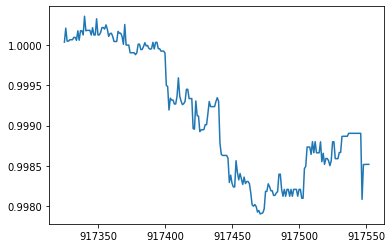

In [13]:
plt.plot(d[d['time_id'] == 32767]['wap1'])

In [14]:
d_0_5 = d[d['time_id'] == 11]

### Strategy: find numerical features for each row_id and apply multiple regression

 - correlation of wap1 and wap2 ***DONE***
 - raw number of book changes in the 10 minutes ***DONE***
 - bid-ask spread features (min, max) ***DONE***
 - volatility for each ***DONE***
 

In [15]:
def diff_with_fill(col1):
    return np.count_nonzero(col1.diff().fillna(0))

def get_wap_correlation(data):
    data = data.groupby(['stock_id', 'time_id'])[['wap1','wap2']].corr().reset_index()
    data = data.iloc[::2,:]
    data = data[['stock_id', 'time_id', 'wap2']]
    data.rename(columns = {'wap2': 'wap_correlation'}, inplace = True)
    return data

def get_book_changes(data):
    data = data.groupby(['stock_id', 'time_id'])[['wap1', 'wap2']].agg(diff_with_fill).reset_index()
    data.rename(columns = {'wap1': 'price_changes1', 'wap2': 'price_changes2'}, inplace = True)
    return data

def get_spread_features(data):
    grouped = data.groupby(['stock_id', 'time_id'])[['spread1','spread2']]
    max_spread = grouped.max().reset_index()
    min_spread = grouped.min().reset_index()
    max_spread.rename(columns = {'spread1': 'max_spread1', 'spread2': 'max_spread2'}, inplace = True)
    min_spread.rename(columns = {'spread1': 'min_spread1', 'spread2': 'min_spread2'}, inplace = True)
    return max_spread.merge(min_spread, 'left', ['stock_id', 'time_id'])

def get_book_volatility(data):
    #volatility1 = realized_volatility(data['log_return1'])
    #volatility2 = realized_volatility(data['log_return2'])
    data = data.groupby(['stock_id', 'time_id'])['log_return1', 'log_return2'].agg(realized_volatility).reset_index()
    data.rename(columns = {'log_return1': 'volatility1', 'log_return2': 'volatility2'}, inplace = True)
    return data

In [16]:
def insert_features(stock_id):
    train = get_train_data(stock_id)
    book = get_book_data(stock_id, book_filepath)
    train = train.merge(get_wap_correlation(book), 'left', ['stock_id', 'time_id'])
    train = train.merge(get_book_changes(book), 'left', ['stock_id', 'time_id'])
    train = train.merge(get_spread_features(book), 'left', ['stock_id', 'time_id'])
    train = train.merge(get_book_volatility(book), 'left', ['stock_id', 'time_id'])
    return train

def insert_all_features():
    frames = []
    for stock in book_filenames:
        frames.append(insert_features(stock))
    return pd.concat(frames)

train_with_features = insert_all_features()

C:\Users\Student\AppData\Local\Temp/ipykernel_14812/1430676705.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data = data.groupby(['stock_id', 'time_id'])['log_return1', 'log_return2'].agg(realized_volatility).reset_index()


## LinearRegression

In [25]:
# Linear regression

train_features = train_with_features.iloc[:, 3:]
train_labels = train_with_features['target']

feature_columns = train_features.columns

scaler = preprocessing.MinMaxScaler().fit(train_features)
train_features_scaled = scaler.transform(train_features)

#x train - features for training
#y train - labels for training
#x test - features for testing
#y test - labels for testing
X_train, X_test, y_train, y_test = train_test_split(train_features_scaled, train_labels, test_size=0.2)

linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)

predict_train = linear_regression.predict(X_train)
predict_test = linear_regression.predict(X_test)

training_r2 = r2_score(y_train, predict_train)
testing_r2 = r2_score(y_test, predict_test)

training_mape = mape(y_train, predict_train)
testing_mape = mape(y_test, predict_test)


print("Training r squared: ", training_r2)
print("Testing r squared: ", testing_r2)
print("Training mean absolute percentage error: ", training_mape)
print("Testing mean absolute percentage error: ", testing_mape)

model_coeff = {'feature': feature_columns, 'coefficient': linear_regression.coef_}
model_info = pd.DataFrame(model_coeff)
model_info


Training r squared:  0.6843281907160065
Testing r squared:  0.6808270077319358
Training mean absolute percentage error:  0.32151201921561334
Testing mean absolute percentage error:  0.32105514439183996


,feature,coefficient
0,wap_correlation,0.000806
1,price_changes1,-0.002543
2,price_changes2,0.005290
3,max_spread1,0.041643
4,max_spread2,-0.007344
5,min_spread1,0.008274
6,min_spread2,0.002664
7,volatility1,-0.023840
8,volatility2,0.049422


## Ridge Regression

In [26]:
#x train - features for training
#y train - labels for training
#x test - features for testing
#y test - labels for testing
X_train, X_test, y_train, y_test = train_test_split(train_features_scaled, train_labels, test_size=0.2)

ridge_regression = Ridge(alpha=0.1)

ridge_regression.fit(X_train, y_train)

predict_train = ridge_regression.predict(X_train)
predict_test = ridge_regression.predict(X_test)

training_r2 = r2_score(y_train, predict_train)
testing_r2 = r2_score(y_test, predict_test)

training_mape = mape(y_train, predict_train)
testing_mape = mape(y_test, predict_test)


print("Training r squared: ", training_r2)
print("Testing r squared: ", testing_r2)
print("Training mean absolute percentage error: ", training_mape)
print("Testing mean absolute percentage error: ", testing_mape)

model_coeff = {'feature': feature_columns, 'coefficient': ridge_regression.coef_}
model_info = pd.DataFrame(model_coeff)
model_info



Training r squared:  0.6841224830371924
Testing r squared:  0.6816527146696145
Training mean absolute percentage error:  0.3222635842749455
Testing mean absolute percentage error:  0.3210900192964821


,feature,coefficient
0,wap_correlation,0.000875
1,price_changes1,-0.002584
2,price_changes2,0.005319
3,max_spread1,0.042426
4,max_spread2,-0.008271
5,min_spread1,0.008622
6,min_spread2,0.002676
7,volatility1,-0.022992
8,volatility2,0.048392
